<a href="https://colab.research.google.com/github/tanjinprity4/SEAssignment1/blob/master/Copy_of_GradAdmissionFinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview

As fourth-year international students who would love to go to a renowned Grad school, we wanted to use our Data Science expertise to explore the state of Grad Admissions in the US. This will not only help us prepare for our path to Academia but will educate us on some seemingly unknown facts about the state of Grad School in the US.

In [ ]:
prob_1 = []
prob_2 = []
prob_3 = []

for sample in samples_uni_admits:
    admits_avg = sample.Admits.mean()
    enroll_avg = sample.Enroll.mean()
    
    if admits_avg >= 210000 and enroll_avg >= 85000:
        prob_1.append(1)
    else:
        prob_1.append(0)
    
    enroll_count = sample.Enroll.sum()
    admit_count = sample.Admits.sum()
    
    if enroll_count < admit_count:
        prob_2.append(1)
    else:
        prob_2.append(0)
        
    num_apps = sample.Apps.mean()
    admit_rate = sample["Admit Rate"].mean()
    
    if num_apps >= 1000000 and admit_rate < 0.2 or num_apps <= 1000000 and admit_rate > 0.2:
        prob_3.append(1)
    else:
        prob_3.append(0)
        
            
p1 = sum(prob_1) / len(samples)
p2 = sum(prob_2) / len(samples)
p3 = sum(prob_3) / len(samples)
print("Probability of two events both happening:")
print("Admision and enrollment are both high", p1)
print()
print("Probability of a event NOT happening:")
print("Enrollment is higher than the number of admitted students", p2)
print()
print("Probability of two equally likely events happening:")
print("Years having huge number of applications having low admission rates (below 20%)") 
print("and years having low number of applications having higher admission rates. ", p3)

Probability of two events both happening:
Admision and enrollment are both high 0.96

Probability of a event NOT happening:
Enrollment is higher than the number of admitted students 1.0

Probability of two equally likely events happening:
Years having huge number of applications having low admission rates (below 20%)
and years having low number of applications having higher admission rates.  0.4


# Testing Hypothesis

# Kaushik's Hypothesis

**Kaushik's Hypothesis: Does Higher GRE Score increases your chances of getting into Grad School?**

**Null Hypothesis:** Higher GRE Score does NOT increase your chances of getting into Grad School.
<br>
**Alternative Hypothesis:** Higher GRE Score increases your chances of getting into Grad School.

## Test Statistics 
**The test statistics will be the difference of mean acceptance rate of the dataset and the high GRE score applicants.**<br><br>
`test_statistic = mean_acceptance_rate_high_gre_scores - mean_acceptance_rate`

## Observed Values

In [ ]:
prob = []
for sample in samples:
    acceptance_mean_high_scorers = (sample.query('(GRE_Score >= 302)').Chance_of_Admit.mean())
    acceptance_mean = sample.Chance_of_Admit.mean()
    diff = acceptance_mean_high_scorers - acceptance_mean
    if diff >= 0.02:
        prob.append(1)
    else:
        prob.append(0)
print(sum(prob)/len(prob))

0.82


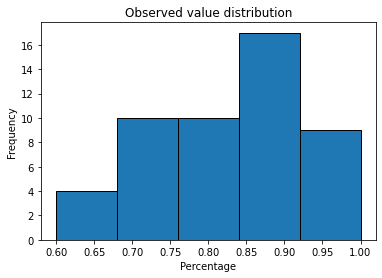

In [ ]:
# Running the sampling simulation 50 times.
final_probabilities = []
for _ in range(50):
    step = 3
    samples = []
    for _ in range(10):
        samples.append(systematic_sampling(grad_admission, step))
    prob = []
    for sample in samples:
        acceptance_mean_high_scorers = (sample.query('(GRE_Score >= 302)').Chance_of_Admit.mean())
        acceptance_mean = sample.Chance_of_Admit.mean()
        diff = acceptance_mean_high_scorers - acceptance_mean
        if diff >= 0.02:
            prob.append(1)
        else:
            prob.append(0)
    final_probabilities.append(sum(prob)/len(prob))

plt.hist(final_probabilities,bins=5, ec='black')
plt.xlabel("Percentage")
plt.ylabel("Frequency")
plt.title("Observed value distribution")
plt.show()

## Calculating p-value

In [ ]:
# Let's use chisquare to calculate the p-value
chisquare(grad_admission.GRE_Score,grad_admission.Chance_of_Admit)

Power_divergenceResult(statistic=57133168.57405691, pvalue=0.0)

**We can see that the p-value is less that 0.05 so, rejecting Null Hypothesis and accepting Alternate Hypothesis. It means chance of admission is depending on GRE Score.**

## Using linear regression and Correlation to support Hypothesis

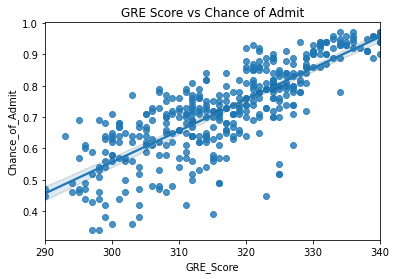

In [ ]:
fig = sns.regplot(x="GRE_Score", y="Chance_of_Admit", data=grad_admission)
plt.title("GRE Score vs Chance of Admit")
plt.show()

In [ ]:
def standard_units(arr):
    return (arr - np.mean(arr))/np.std(arr)
def correlation(arr1, arr2):
    return np.mean(standard_units(arr1)*standard_units(arr2))
gre_vs_chance_of_admit = correlation(grad_admission["GRE_Score"], grad_admission["Chance_of_Admit"])
print("The correlation factor for GRE score to Chance of admit is:", gre_vs_chance_of_admit)

The correlation factor for GRE score to Chance of admit is: 0.8026104595903505


**We can see that we have a very high correlation of about 80%. So, we can say that GRE scores and Chance of admission is dirrectly proportional.**

**We would like to use linear regression to model it.**

In [ ]:
def regression_parameters(x, y):
    y_mean = np.mean(y)
    slope = correlation(x, y)*np.std(y)/np.std(x) 
    intercept = y_mean-(slope*np.mean(x))
    return [slope, intercept]

parameters = regression_parameters(grad_admission["GRE_Score"], grad_admission["Chance_of_Admit"])
parameters

[0.009975882025681386, -2.436084244851056]

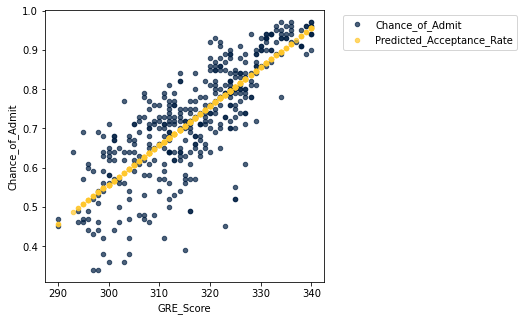

In [ ]:
predicted_acceptance = parameters[0]*grad_admission["GRE_Score"] + parameters[1]

pten = Table.from_df(grad_admission, keep_index= False)
(pten.with_column("Predicted_Acceptance_Rate", predicted_acceptance)
.select("GRE_Score", "Chance_of_Admit", "Predicted_Acceptance_Rate")
 .scatter("GRE_Score"))
plt.ylabel("Chance_of_Admit");

**Now lets try to calculate the RMSE - root mean squared error for this regression model.**

In [ ]:
def RMSE(slope, intercept):
    gre = grad_admission["GRE_Score"]
    acceptance = grad_admission["Chance_of_Admit"]
    predicted_acceptance = slope*gre + intercept
    return (np.mean((acceptance - predicted_acceptance)**2))**0.5

In [ ]:
print('RMSE of Predicted Chance of admission given a GRE score: ', RMSE(parameters[0],parameters[1]))

RMSE of Predicted Chance of admission given a GRE score:  0.08496056727604849


**Using a linear regression model, we can obtain a very good approximation of our chances of getting admitted to a college given out GRE score. This is because our RMSE is very low.**

<AxesSubplot:>

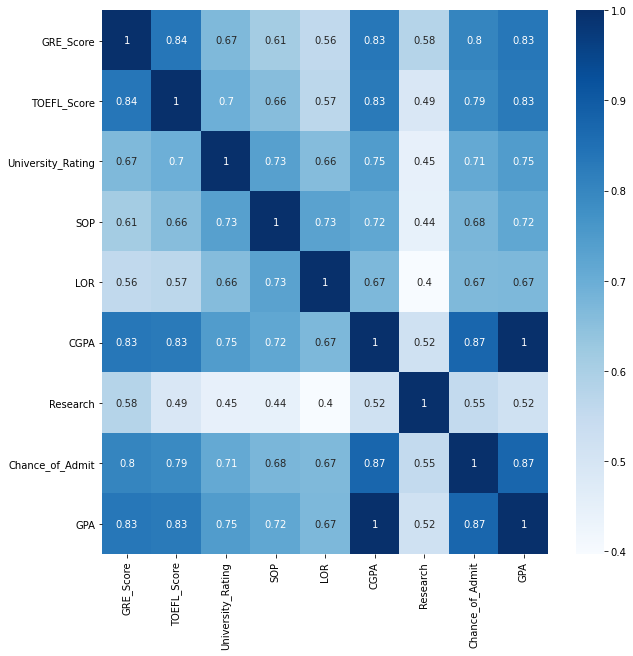

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(grad_admission.corr(), annot=True, cmap='Blues')

In [ ]:
def correlation(arr1, arr2):
    numerator = 0
    denominator_sum_1 = 0
    denominator_sum_2 = 0
    
    mean_x = sum(arr1) / len(arr1)
    mean_y = sum(arr2) / len(arr2)
    
    for i in range(len(arr1)):
        x_i = arr1[i]
        y_i = arr2[i]
        numerator += (x_i - mean_x) * (y_i - mean_y)
        denominator_sum_1 += ((x_i - mean_x)**2)
        denominator_sum_2 += ((y_i - mean_y)**2)
        
    denominator = ((denominator_sum_1 * denominator_sum_2) ** (1/2))
    return (numerator / denominator)

In [ ]:
GRE_vs_Chance_of_Admit = correlation(grad_admission["GRE_Score"], grad_admission["Chance_of_Admit"])
print("The correlation factor for GRE_Score to Chance_of_Admit is:", GRE_vs_Chance_of_Admit)

The correlation factor for GRE_Score to Chance_of_Admit is: 0.8026104595903509


## Hypothesis Tests Conclusions
Based on what you found about your topic communicate it to the audience. 


1. Maximum GRE score is 340 and Minimum GRE Score is 290. Average GRE score is 316.80 with a deviation of 11.47 from mean.Using BoxPlot for this Descriprive Analysis such as Minimum, Maximum and Quartiles.<br>
2. Chi Square test:P value is less than 0.05, So rejecting Null Hypothesis and accepting Alternate Hypothesis. It means chance of admission is depending on GRE Score.<br>
3. With the help of Histogram it is clear that Most of the Students are having GRE Score between 320 and 325.<br>
4. There is a Strong Positive Corelation of 80 % of GRE score with Chance of Admission. This means Chance of admission is increasing with increase in GRE Score. From scatter plot, it is clearly visible that on increasing GRE Score, Chance of Admission is also Increasing.

**So, looking at all this insights and testing out hypothesis using sampling, p-value, linear regression and correlation we reject the NULL hypothesis and accept the ALTERNATIVE hypothesis: Higher GRE Score increases your chances of getting into Grad School.**

# Tanjin's Hypothesis

**Tanjin's Hypothesis: Does Higher Enrollment of Non-resident Alien Decreases the Number of Women enrollment?**


**Null Hypothesis:** Higher enrollment of Non-resident Alien does NOT decrease the percentage of Women enrollment.

**Alternative Hypothesis:** Higher enrollment of Non-resident Alien decreases the percentage of Women enrollment.

## Test Statistics

The test statistics will be the difference of mean women enrollment for universities with high enrollment of non-resident aliens and mean women enrollment for universities with low enrollment of non-resident aliens.

`test_statistic = mean_women_enrollment_for_lower_enrollment_of_nonresident -  mean_women_enrollment_for_higher_enrollment_of_nonresident`

## Observed Values


In [ ]:
print(graduate_enrollment.columns)
print(graduate_enrollment['Nonresident_Alien'].mean())

Index(['Nonresident_Alien', 'Women'], dtype='object')
6.525341914722445


Let's see the difference between `mean_women_enrollment_for_lower_enrollment_of_nonresident` and `mean_women_enrollment_for_higher_enrollment_of_nonresident`. Since the mean of percentage of Nonresident Alien enrollment is `6.53` approximately, we will use it to **divide the samples** into higher and lower enrollments of nonresidents. 


In [ ]:
mean_women_enrollment_for_higher_enrollment_of_nonresident = (graduate_enrollment.query('(Nonresident_Alien >= 6.53)').Women.mean())
mean_women_enrollment_for_lower_enrollment_of_nonresident = (graduate_enrollment.query('(Nonresident_Alien < 6.53)').Women.mean())
test_statistic = mean_women_enrollment_for_lower_enrollment_of_nonresident - mean_women_enrollment_for_higher_enrollment_of_nonresident
test_statistic

10.881359460109174

`test_statitic` value from original dataset is **10.88**. To prove our hypothesis, though it is enough to show that the test statistic produces a **positive value (>0)** for most samples, we will use `9.75` for greater effectiveness and find the probability of getting 9.75 as test statistic in our simulations.

In [ ]:
def simulation_nonresident_and_women(samples_nonresident_and_women):
    prob = []
    for sample in samples_nonresident_and_women:
        mean_women_enrollment_for_higher_enrollment_of_nonresident = (sample.query('(Nonresident_Alien >= 6.53)').Women.mean())
        mean_women_enrollment_for_lower_enrollment_of_nonresident = (sample.query('(Nonresident_Alien < 6.53)').Women.mean())
        diff = mean_women_enrollment_for_lower_enrollment_of_nonresident - mean_women_enrollment_for_higher_enrollment_of_nonresident
        if diff >= 9.75:
            prob.append(1)
        else:
            prob.append(0)
    return sum(prob)/len(prob)
print(simulation_nonresident_and_women(samples_nonresident_and_women))

0.88


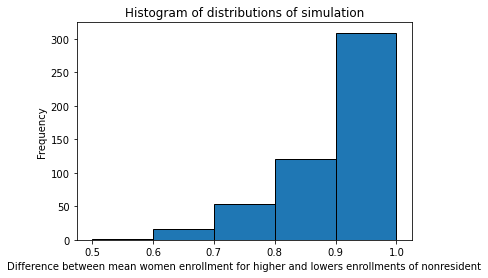

In [ ]:
# Running the sampling simulation 50 times.
final_probabilities = []
for _ in range(500):
    step = 3
    samples_women = []
    for _ in range(10):
        samples_women.append(systematic_sampling(graduate_enrollment, step))
    final_probabilities.append(simulation_nonresident_and_women(samples_women))

plt.hist(final_probabilities,bins=5, ec='black')
plt.xlabel("Difference between mean women enrollment for higher and lowers enrollments of nonresident")
plt.ylabel("Frequency")
plt.title("Histogram of distributions of simulation")
plt.show()

## Calculating p-value

In [ ]:
chisquare(graduate_enrollment.Nonresident_Alien,graduate_enrollment.Women)

Power_divergenceResult(statistic=65666.22701445356, pvalue=0.0)

We can see that the p-value is less that 5%. So, rejecting Null Hypothesis and accepting Alternate Hypothesis. It says higher enrollment of Non-resident Alien decreases the percentage of Women enrollment.

## Using Correlation and Linear regression to support Hypothesis

In [ ]:
def standard_units(arr):
    return (arr - np.mean(arr))/np.std(arr)
def correlation(arr1, arr2):
    return np.mean(standard_units(arr1)*standard_units(arr2))
Nonresident_Alien_vs_Women = correlation(graduate_enrollment["Nonresident_Alien"], graduate_enrollment["Women"])
print("The correlation factor for Nonresident_Alien to Women is:", Nonresident_Alien_vs_Women)

The correlation factor for Nonresident_Alien to Women is: -0.4180892509486783


Negative correlation factor simply shows the opposite trend of these two columns (i.e. higher the percentage of Nonresident_Alien enrollment, lower the percentage of Women enrollment). However, it isn't a very strong correlation since the absolute value is less than 0.5.

Let's apply linear regression. We will find **regression parameters** first.

In [ ]:
def regression_parameters(x, y):
    y_mean = np.mean(y)
    slope = correlation(x, y)*np.std(y)/np.std(x) 
    intercept = y_mean-(slope*np.mean(x))
    return [slope, intercept]

parameters = regression_parameters(graduate_enrollment["Nonresident_Alien"], graduate_enrollment["Women"])
parameters

[-0.6841768295563544, 68.13705411466741]

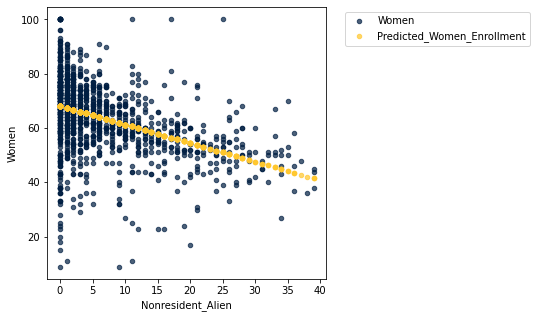

In [ ]:
predicted_women_enrollment = parameters[0]*graduate_enrollment["Nonresident_Alien"] + parameters[1]

pten2 = Table.from_df(graduate_enrollment, keep_index= False)
(pten2.with_column("Predicted_Women_Enrollment", predicted_women_enrollment)
.select("Nonresident_Alien", "Women", "Predicted_Women_Enrollment")
 .scatter("Nonresident_Alien"))
plt.ylabel("Women");

Let's look at the root mean square error for our linear regression model.

In [ ]:
def RMSE(slope, intercept):
    nonresident_alien = graduate_enrollment["Nonresident_Alien"]
    women = graduate_enrollment["Women"]
    predicted_women = slope*nonresident_alien + intercept
    return (np.mean((women - predicted_women)**2))**0.5


In [ ]:
print('RMSE of Predicted Enrollment of Women: ', RMSE(parameters[0],parameters[1]))

RMSE of Predicted Enrollment of Women:  12.34035379042034


Using a linear regression model, we would not be able to obtain a very accurate prediction for most of the points which is why we obtained high RMSE for this model. This is because our scatter plot of Nonresident_Alien enrollment vs Women enrollment is more scattered rather than forming a line which produce high RMSE in a linear regression model.

## Hypothesis Tests Conclusions

1. Difference between mean of Women Enrollment in Universities having LOW Nonresident Alien Enrollment and HIGH Nonresident Alien Enrollment is a positive value. The probability of the difference being greater than 9.75 is about **0.87**.
2. Chi Square test:P value is less than 0.05, So rejecting Null Hypothesis and accepting Alternate Hypothesis. It means higher enrollment of Non-resident Alien decreases the percentage of Women enrollment.
3. There is a **Negative Correlation of 42%** of High Nonresident Alien Enrollment with Low Women Enrollment. From scatter plot, we can see that on increasing Nonresident Alien Enrollment, Women Enrollment is decreasing. This means high percentage of enrollment of Non-resident Alien decreases the percentage of Women enrollment. 
4. Linear regression model with **RMSE 12.34** loosely supports this hypothesis conclusion.

So, looking at all this insights and testing out hypothesis using sampling, p-value, correlation, and linear regression, we reject the NULL hypothesis and accept the ALTERNATIVE hypothesis: **High percentage of Non-resident Alien enrollment decreases the percentage of Women enrollment.**

# Pujan's Hypothesis
**Pujan's Hypothesis: Does the admission rate decrease with higher number of applicants?**

**Null Hypothesis:** Higher number of applications does not decrease admission rate.
<br>
**Alternative Hypothesis:** Higher number of applications decreases admission rate.

## Test Statistics

The test statistics will be the difference of mean admit rate for years with high number of applications and the mean admit rate for years with low number of applications. 

`test_statistic = mean_admit_rate_for_high_apps -  mean_women_enrollment_for_low_apps`

## Observed Values

In [ ]:
print(private_uni_admits.columns)
print(private_uni_admits['Apps'].mean())

Index(['Admit Year', 'Apps', 'Admits', 'Enroll', 'Admit Rate', 'Admit:Enroll'], dtype='object')
1048592.1578947369


Let's see the difference between `mean_admit_rate_for_high_apps` and `mean_admit_rate_for_low_apps`. Since the mean of number of applications is `1048592` approximately, we will use it to **divide the samples** into higher and lower number of applications. 

In [ ]:
def simulation_admit_rates(samples):
    prob = []
    for sample in samples:
        mean_admit_rate_for_high_apps = sample[sample['Apps'] >= 1048592]['Admit Rate'].mean()
        mean_admit_rate_for_low_apps = sample[sample['Apps'] <= 1048592]['Admit Rate'].mean()
        diff = mean_admit_rate_for_high_apps - mean_admit_rate_for_low_apps
        if diff <= 0:
            prob.append(1)
        else:
            prob.append(0)
    return sum(prob)/len(prob)
print(simulation_admit_rates(samples_uni_admits))

0.99


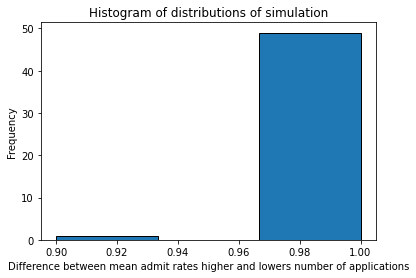

In [ ]:
# Running the sampling simulation 50 times.
final_probabilities = []
for _ in range(50):
    step = 3
    samples = []
    for _ in range(10):
        samples.append(systematic_sampling(private_uni_admits, step))
    final_probabilities.append(simulation_admit_rates(samples))

plt.hist(final_probabilities,bins=3, ec='black')
plt.xlabel("Difference between mean admit rates higher and lowers number of applications")
plt.ylabel("Frequency")
plt.title("Histogram of distributions of simulation")
plt.show()

## Calculating p-value

In [ ]:
chisquare(private_uni_admits['Apps'], private_uni_admits['Admit Rate'])

Power_divergenceResult(statistic=122183830348789.98, pvalue=0.0)

We can see that the p-value is less that 5%. So, we reject the Null Hypothesis and accept the Alternate Hypothesis. It says that higher number of applications decreases admission rate.

## Using Correlation and Linear regression to support Hypothesis

In [ ]:
def standard_units(arr):
    return (arr - np.mean(arr))/np.std(arr)
def correlation(arr1, arr2):
    return np.mean(standard_units(arr1)*standard_units(arr2))
admit_rates_vs_apps = correlation(private_uni_admits["Apps"], private_uni_admits["Admit Rate"])
print("The correlation factor for number of applications to Admit Rate is:", admit_rates_vs_apps)

The correlation factor for number of applications to Admit Rate is: -0.9969702496170519


Negative correlation factor simply shows the opposite trend of these two columns (i.e. higher the percentage of Nonresident_Alien enrollment, lower the percentage of Women enrollment). However, it isn't a very strong correlation since the absolute value is less than 0.5.

Let's apply linear regression. We will find **regression parameters** first.

In [ ]:
def regression_parameters(x, y):
    y_mean = np.mean(y)
    slope = correlation(x, y)*np.std(y)/np.std(x) 
    intercept = y_mean-(slope*np.mean(x))
    return [slope, intercept]

parameters = regression_parameters(private_uni_admits["Apps"], private_uni_admits["Admit Rate"])
parameters

[-1.782673634698589e-07, 0.4196666014483279]

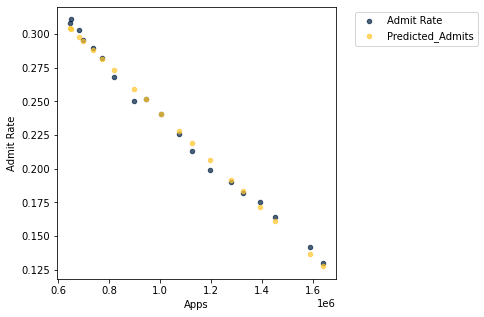

In [ ]:
predicted_admit_rate = parameters[0]*private_uni_admits["Apps"] + parameters[1]

pten3 = Table.from_df(private_uni_admits, keep_index= False)
(pten3.with_column("Predicted_Admits", predicted_admit_rate)
.select("Apps", "Admit Rate", "Predicted_Admits")
 .scatter("Apps"))
plt.ylabel("Admit Rate");

Let's look at the root mean square error for our linear regression model.

In [ ]:
def RMSE(slope, intercept):
    apps = private_uni_admits["Apps"]
    admit_rate = private_uni_admits["Admit Rate"]
    predicted_admit_rate = slope*apps + intercept
    return (np.mean((admit_rate - predicted_admit_rate)**2))**0.5

In [ ]:
print('RMSE of Predicted Admit rate and actual value: ', RMSE(parameters[0],parameters[1]))

RMSE of Predicted Admit rate and actual value:  0.00441585402902118


Using a linear regression model, we were able to verify the fact that there is a negative corelation between the number of applications and admit rate. 

## Hypothesis Tests Conclusions


1. Difference between mean admit rate for high number of applications is lower than the mean admit rate for low number of applications. The probability of this happening is about 0.97.
2. Chi Square test:P value is less than 0.05, So rejecting Null Hypothesis and accepting Alternate Hypothesis. It means that for high number of applications, the admit rate is lower.
3. There is a Negative Correlation of 99.7% of High number of applications with admit rate. From scatter plot, we can see that if we increase the number of applications, the admit rates decreases. This means that higher the number of applications, lower the admit rate. 
4. Linear regression model  supports this hypothesis conclusion.

So, looking at all this insights and testing out hypothesis using sampling, p-value, correlation, and linear regression, we reject the NULL hypothesis and accept the ALTERNATIVE hypothesis: **High number of applications decrease admission rate.**

# Topic Conclusions

**So, now to summarise we can conclude by saying:<br>
    1. Higher GRE Score increases your chances of getting into Grad School.<br>
    2. Higher enrollment of Non-resident Alien decreases the percentage of Women enrollment.<br>
    3. Higher number of applicants decrease the admission rate.**

# Limitations

Here are the few limitations of our project:
1. It only talks about US admissions so, if your dream school is not in the US these analysis might not help you.
2. We can not use this analysis to extrapulate anything about undergraduate admissions because they have a very different admission process.
3. These datasets might not be able to help you with a specific school or major.

# Footnote on Ethics and Transparency

1. We understand that people might get mixed feelings seeing such a high correlation between grad admissions and GRE scores. However, there are few things we want to be TRANSPARENT about:
    1. This prediction will only work for US colleges
    2. The dataset does not give much idea about what field of study versus GRE scores
2. We understand that people might get sad seeing that higher the number of international student, the percent of women goes down. This claim might make the international community sad. We are NOT accusing  any community here or INADVERTENTLY AFFECTING them. The observed stats has such behaviour because most international students are men.
